# Glaucoma Prediction Model

### Step 1: Import libraries

In [1]:
import os, glob, cv2, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from sklearn.model_selection import train_test_split

C:\Users\rocky\AppData\Local\Temp\ipykernel_39864\852393205.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Step 2: Read dataset

In [2]:
df = pd.read_csv("C:/Users/rocky/OneDrive/Desktop/Ocular-Disease-Recognition/data/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


### Step 3. Extracting Glaucoma & Normal information from the dataset

##### Myopia images

In [3]:
def has_glaucoma(text):
    if "glaucoma" in text:
        return 1
    else:
        return 0

In [4]:
df["left_glaucoma"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
df["right_glaucoma"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))

In [5]:
left_glaucoma = df.loc[(df.G ==1) & (df.left_glaucoma == 1)]["Left-Fundus"].values
left_glaucoma[:15]

array(['95_left.jpg', '153_left.jpg', '167_left.jpg', '178_left.jpg',
       '247_left.jpg', '365_left.jpg', '583_left.jpg', '625_left.jpg',
       '746_left.jpg', '931_left.jpg', '1209_left.jpg', '1210_left.jpg',
       '1211_left.jpg', '1212_left.jpg', '1213_left.jpg'], dtype=object)

In [6]:
right_glaucoma = df.loc[(df.G ==1) & (df.right_glaucoma == 1)]["Right-Fundus"].values
right_glaucoma[:15]

array(['43_right.jpg', '167_right.jpg', '238_right.jpg', '247_right.jpg',
       '365_right.jpg', '583_right.jpg', '746_right.jpg', '931_right.jpg',
       '1209_right.jpg', '1210_right.jpg', '1211_right.jpg',
       '1212_right.jpg', '1213_right.jpg', '1214_right.jpg',
       '1215_right.jpg'], dtype=object)

In [7]:
print("Number of images in left glaucoma: {}".format(len(left_glaucoma)))
print("Number of images in right glaucoma: {}".format(len(right_glaucoma)))

Number of images in left glaucoma: 332
Number of images in right glaucoma: 284


##### Normal images

In [10]:
left_normal = df.loc[(df.G ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(308,random_state=42).values
right_normal = df.loc[(df.G ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(308,random_state=42).values

In [11]:
glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

print(len(glaucoma),len(normal))

616 616


### Step 4: Creating dataset from images

In [12]:
image_set_dir = "C:/Users/rocky/OneDrive/Desktop/URO/dataset/archive/preprocessed_images"

image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(image_set_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [14]:
dataset = create_dataset(glaucoma, 1)

100%|██████████| 616/616 [00:08<00:00, 76.71it/s]


In [15]:
len(dataset)

1226

In [16]:
dataset = create_dataset(normal, 0)

100%|██████████| 616/616 [00:19<00:00, 30.81it/s]


In [17]:
len(dataset)

1842

##### Image presentation

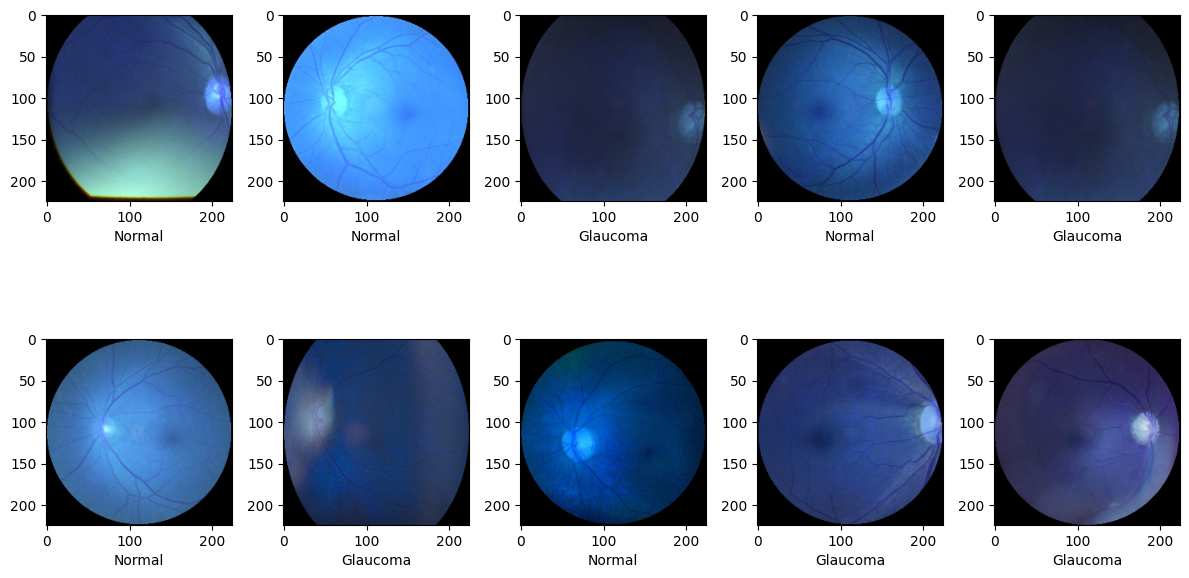

In [18]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Glaucoma"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

##### Dividing dataset into x (features) & y (target)

In [19]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

### Step 5: Creating Model

In [20]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [21]:
for layer in vgg.layers:
    layer.trainable = False

In [22]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [24]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

##### Early stopping for statistical optimization

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [26]:
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [27]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15


47/47 [==============================] - 569s 12s/step - loss: 2.1500 - accuracy: 0.7400 - val_loss: 0.7393 - val_accuracy: 0.8699
Epoch 2/15
47/47 [==============================] - 363s 8s/step - loss: 0.2617 - accuracy: 0.9362 - val_loss: 0.3846 - val_accuracy: 0.9024
Epoch 3/15
47/47 [==============================] - 379s 8s/step - loss: 0.0810 - accuracy: 0.9715 - val_loss: 0.2709 - val_accuracy: 0.9268
Epoch 4/15
47/47 [==============================] - 588s 13s/step - loss: 0.0327 - accuracy: 0.9919 - val_loss: 0.3023 - val_accuracy: 0.9350
Epoch 5/15
47/47 [==============================] - 727s 16s/step - loss: 0.0096 - accuracy: 0.9973 - val_loss: 0.5680 - val_accuracy: 0.9187
Epoch 6/15
47/47 [==============================] - 886s 19s/step - loss: 0.0161 - accuracy: 0.9952 - val_loss: 0.2920 - val_accuracy: 0.9404
Epoch 7/15
47/47 [==============================] - 864s 18s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2751 - val_accuracy: 0.9350
Epoch 

In [28]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

12/12 [==============================] - 67s 6s/step - loss: 0.2942 - accuracy: 0.9350
loss: 0.29422134160995483
Accuracy: 0.934959352016449


In [29]:
pred_y=model.predict(x_test)
y_pred=(pred_y > 0.5).astype("int32")

12/12 [==============================] - 69s 6s/step


In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9349593495934959

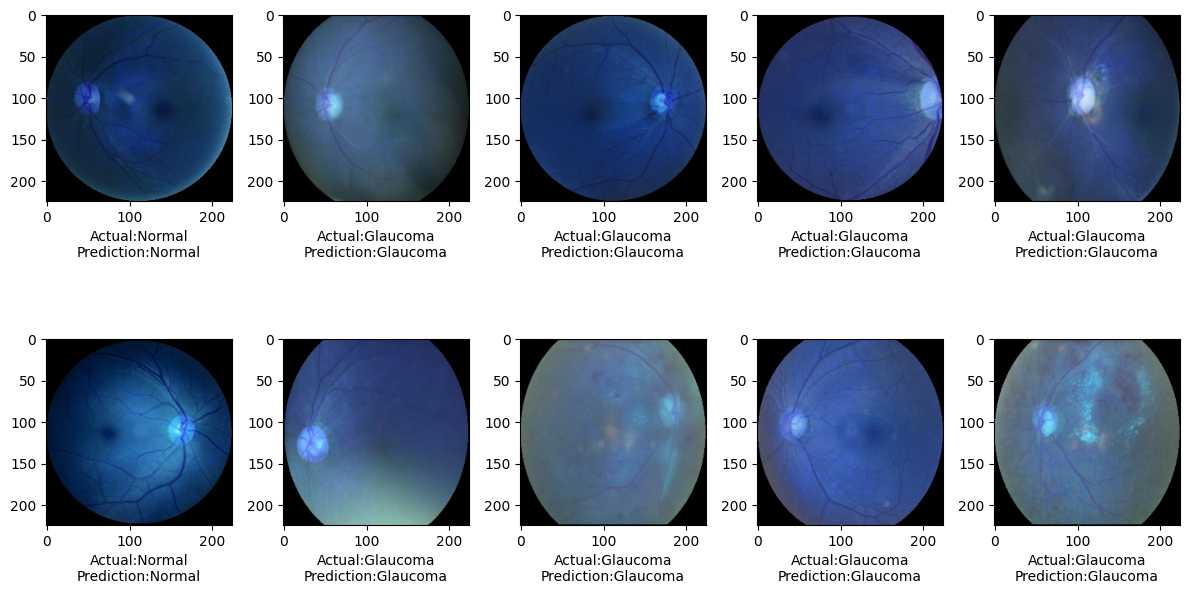

In [39]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Glaucoma"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Glaucoma"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))

plt.tight_layout() 

In [40]:
model.save('C:/Users/rocky/OneDrive/Desktop/Ocular-Disease-Recognition/models/glaucoma_model.h5')

c:\Users\rocky\OneDrive\Desktop\Ocular-Disease-Recognition\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
